In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import re
import nethelp as nh
import powerlaw


In [2]:
import graph_tool.all as gt

## Reading in the data
I have the data saved in individual json files for each doctor. So here I am constructing a NetworkX based by creating a link between the doctor's ID number and each of the institutions they trained at or hospitals they are affiliated with. I want to add edge attributes for the years they attended each institution and whether it was undergrad/MD/residency/fellowship, doctor node attributes for where they currently are and their job title, specialty, sub-specialty and awards, and institution node attributes for university/hospital and hopefully rank.

In [3]:
def extract_years(date_string):
    """
    Extracts start and end years from a string formatted as 'YYYY - YYYY'.

    This function looks for a date range in the format 'YYYY - YYYY' within the given string.
    If found, it extracts and returns the start year and end year as integers.

    Parameters
    ----------
    date_string : str
        The string that may contain a date range in the 'YYYY - YYYY' format.

    Returns
    -------
    tuple or None
        A tuple containing two integers: (start_year, end_year) if the pattern is found.
        Returns None if the pattern is not found.

    Examples
    --------
    >>> extract_years("Event happened between 1995 - 2000")
    (1995, 2000)

    >>> extract_years("No date here")
    None
    """
    # Define a regex pattern for 'YYYY - YYYY'
    pattern = r'(\d{4})\s*-\s*(\d{4})'
    
    # Search for the pattern in the input string
    match = re.search(pattern, date_string)
    
    if match:
        # Extract the start and end years from the match groups
        start_year = int(match.group(1))
        end_year = int(match.group(2))
        return start_year, end_year
    else:
        return None  # Return None if no match is found


In [4]:
def parse_training_data(link_attributes, institution, order):
    """
    Parses a list of educational or training attributes to extract relevant details such as 
    degree level, subject, start year, end year, and awards. The function handles various 
    formats and patterns in the input data and applies specific rules based on the presence 
    of keywords like 'residency', 'fellowship', and 'class of', and adjusts for special cases 
    such as osteopathic institutions ('DO' degrees).

    Parameters:
    -----------
    link_attributes : list of str
        A list containing details about an individual's training or education at a particular 
        institution. Each entry can represent degree level, subject, year range, or other details.
        
    institution : str
        The name of the institution where the training or education took place. This is 
        checked for keywords such as 'osteopath' to infer specific degree levels like 'DO'.
        
    order : int
        An integer representing the order of the training or education in the individual's 
        trajectory, used for tracking sequence in a graph or timeline.

    Returns:
    --------
    dict
        A dictionary with the following keys:
        - 'level' : str or None
            The training level or degree (e.g., 'MD', 'PhD', 'Fellowship', 'Residency').
        - 'order' : int
            The order of the training or education, as passed in the input.
        - 'subject' : str or None
            The subject or field of study (e.g., 'Biology', 'Cardiology').
        - 'start' : int or None
            The start year of the training/education.
        - 'end' : int or None
            The end year of the training/education.
        - 'award' : str or None
            Any awards or honors mentioned (e.g., 'Cum Laude', 'Honors').

    Example:
    --------
    >>> parse_training_data(['Fellowship', 'Cardiology', '2005 - 2007'], 'Harvard University', 1)
    {'level': 'fellowship', 'order': 1, 'subject': 'cardiology', 'start': 2005, 'end': 2007, 'award': None}

    >>> parse_training_data(['Class of 2005'], 'NYIT College Of Osteopathic Medicine', 2)
    {'level': 'do', 'order': 2, 'subject': None, 'start': 2001, 'end': 2005, 'award': None}
    """
    level = None
    subject = None
    start_date = None
    end_date = None
    award = None 
    
    l = -1
    for entry in link_attributes:
        
        # training level 
        l = l + 1
        result = extract_years(entry)
        if 'class of' in entry.lower():
            level = 'md'
            # topic = None
            start_date = int(entry.split()[-1]) - 4
            end_date = int(entry.split()[-1])

        elif l == 0:

            if 'residency' in entry.lower():
                level = 'residency' 
                # start = start = int(entry.split()[-3]) # this needs to be its own if clause becuase the date is not going to be in the same entry as residency
                
            elif 'postdoc' in entry.lower().replace('-', ''):
                level = 'postdoc'
            
            elif 'fellowship' in entry.lower(): 
                level = 'fellowship'
            
            elif 'intern' in entry.lower():
                level = 'internship'

            elif 'intern' in entry.lower():
                level = 'internship'

            elif 'phd' in entry.lower().replace('.', ''):
                level = 'phd'

            elif 'mph' in entry.lower().replace('.', ''):
                level = 'mph'

            elif 'ba' in entry.lower().replace('.', ''):
                level = 'ba'
            
            elif 'bs' in entry.lower().replace('.', ''):
                level = 'bs'
            
            else:
                level = entry.lower().replace('.','')
        
        elif 'do' == entry.lower().replace('.',''):
            level = 'do'
        # start and end dates
        elif result:
            start_date, end_date = result
        
        # awards
        elif 'cum' in entry.lower():
            award = entry.lower()
        elif 'honor' in entry.lower() or 'honour' in entry.lower():
            award = entry.lower()

        # assume anything else is subject 
        else:
            subject = entry.lower()

    if 'osteopath' in institution.lower():
        level = 'do'
        
    parsed_dict = {
        'level': level,
        'order': order,
        'subject': subject,
        'start': start_date,
        'end': end_date,
        'award': award
    }
    return parsed_dict


In [5]:
data

NameError: name 'data' is not defined

In [6]:
%pwd

'/Users/nima/Desktop/PhD/NETS 5116/physician_trajectories/code'

In [7]:
i = -1
G = nx.Graph()
edge_count = 0
institutions = set()
# hospitals = set()
errors = 0
while i <= 38970: # total number of files
    i = i + 1 # increment counter
    try:
        filepath = '../../physician_trajectories/data/card/' + str(i) + '.json' # construct filepath
        with open(filepath, 'r') as f:
            data = json.load(f) # load json as dict
            G.add_node(i, 
                       bipartite = 0, 
                       first_name = data[str(i)]['first_name'],
                       last_name = data[str(i)]['last_name'],
                       specialty = data[str(i)]['specialty'],
                       sub_specialty = data[str(i)]['sub_specialty'],
                       office = data[str(i)]['office'],
                       job_titles = data[str(i)]['job_titles'],
                       awards = data[str(i)]['awards'])

            if data.get(str(i)).get('training'):
                for keys, vals in data.get(str(i)).get('training').items(): # iterate through 'training'
                    inst = list(vals.keys())[0]
                    institutions.add(inst) # add institution to set
                    parsed_dict = parse_training_data(link_attributes=list(vals.values())[0], institution=inst, order=int(keys))
                    # create edge between doctor id and institution
                    G.add_node(inst, bipartite = 1) # hopefully add university metadata here
                    G.add_edge(
                        i, 
                        inst, 
                        level = parsed_dict['level'], 
                        order = parsed_dict['order'], 
                        subject = parsed_dict['subject'], 
                        start = parsed_dict['start'], 
                        end = parsed_dict['end'], 
                        award = parsed_dict['award']
                    )
                for line in data.get(str(i)).get('hospital'):
                    institutions.add(line) # add hospital to set
                    G.add_node(line, bipartite = 1)
                    G.add_edge(i, line) # create edge between doctor and hospital
    except Exception as e:
        # todo: make more informative error handling
        errors = errors + 1

In [8]:
errors

432

In [9]:
nx.is_bipartite(G)

True

In [10]:
G.number_of_nodes()
list(G.edges(data=True))[:10]
list(G.nodes(data=True))[:10]

[(1,
  {'bipartite': 0,
   'first_name': 'A. Vincent',
   'last_name': 'Songco',
   'specialty': 'Cardiology',
   'sub_specialty': 'Echocardiography, Interventional Cardiology, Nuclear Cardiology',
   'office': '730 N. Macomb St.Suite 428AMonroe, MI 48162',
   'job_titles': ['Physician', ''],
   'awards': ['Maria and Sam Miller Professional Excellence Award - Scientific Achievement Award in Clinical Research Cleveland Clinic Foundation, 2012',
    'CMS Meaningful Use Stage 1 Certification EpicCare Ambulatory EMR, Epic Systems Corporation, 2011, 2013',
    'American College of Cardiology/Bristol Laboratories Affiliate Travel Award Cleveland Clinic Foundation, 1993',
    'Research Day Award for Clinical Fellows Cleveland Clinic Foundation, 1992',
    'Fellow American Heart Association, 1991',
    'With University Honors Carnegie-Mellon University',
    'Alpha Omega Alpha Johns Hopkins University',
    'Franklin Paine Mall Award for Cell Biology and Anatomy Johns Hopkins University',
    

## Whole network properties

### Degree distribution
The degree distribution of the whole cardiology network seems to follow a power law but I need to fit it to say whether its 'scale-free' or not. This is the whole network including doctors and institutions so I think that's why theres a weird hump near at low degrees because I think the doctors degrees will probably follow more of a poisson distribution but the institutions might be scale free, but here we're getting the amalgamation of both.

In [17]:
def degree_distribution(G, number_of_bins=15, log_binning=True, density=True, directed=False):
    """
    Given a degree sequence, return the y values (probability) and the
    x values (support) of a degree distribution that you're going to plot.

    Parameters
    ----------
    G (nx.Graph):
        the network whose degree distribution to calculate

    number_of_bins (int):
        length of output vectors

    log_binning (bool):
        if you are plotting on a log-log axis, then this is useful

    density (bool):
        whether to return counts or probability density (default: True)
        Note: probability densities integrate to 1 but do not sum to 1.

    directed (bool or str):
        if False, this assumes the network is undirected. Otherwise, the
        function requires an 'in' or 'out' as input, which will create the
        in- or out-degree distributions, respectively.

    Returns
    -------
    bins_out, probs (np.ndarray):
        probability density if density=True node counts if density=False; binned edges

    """

    if type(G) == nx.Graph:
        # Step 0: Do we want the directed or undirected degree distribution?
        if directed:
            if directed == 'in':
                k = list(dict(G.in_degree()).values())  # get the in degree of each node
            elif directed == 'out':
                k = list(dict(G.out_degree()).values())  # get the out degree of each node
            else:
                out_error = "Help! if directed!=False, the input needs to be either 'in' or 'out'"
                print(out_error)
                # Question: Is this the correct way to raise an error message in Python?
                #           See "raise" function...
                return out_error
        else:
            k = list(dict(G.degree()).values())  # get the degree of each node

    # Step 1: We will first need to define the support of our distribution
    kmax = np.max(k)  # get the maximum degree
    kmin = 0  # let's assume kmin must be 0

    # Step 2: Then we'll need to construct bins
    if log_binning:
        # array of bin edges including rightmost and leftmost
        bins = np.logspace(0, np.log10(kmax + 1), number_of_bins + 1)
    else:
        bins = np.linspace(0, kmax + 1, num=number_of_bins + 1)

    # Step 3: Then we can compute the histogram using numpy
    probs, _ = np.histogram(k, bins, density=density)

    # Step 4: Return not the "bins" but the midpoint between adjacent bin
    #         values. This is a better way to plot the distribution.
    bins_out = bins[1:] - np.diff(bins) / 2.0

    return bins_out, probs

In [11]:
def bipartite_degrees(B, number_of_bins=15, log_binning_0=True, log_binning_1 = True, density=True,):

    group_0_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
    group_1_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}

    group_0_degrees = [B.degree(n) for n in group_0_nodes]
    group_1_degrees = [B.degree(n) for n in group_1_nodes]

    # Step 1: We will first need to define the support of our distribution
    kmax_0 = np.max(group_0_degrees)  # get the maximum degree
    kmax_1 = np.max(group_1_degrees)  # get the maximum degree
    kmin_0 = np.min(group_0_degrees)  # 
    kmin_1 = np.min(group_1_degrees)  # 

    # Step 2: Then we'll need to construct bins
    if log_binning_0:
        # array of bin edges including rightmost and leftmost
        bins = np.logspace(0, np.log10(kmax_0 + 1), number_of_bins + 1)
    else:
        bins = np.linspace(0, kmax_0 + 1, num=number_of_bins + 1)

    # Step 3: Then we can compute the histogram using numpy
    probs_0, _ = np.histogram(group_0_degrees, bins, density=density)
    bins_out_0 = bins[1:] - np.diff(bins) / 2.0

    # Step 2: Then we'll need to construct bins
    if log_binning_1:
        # array of bin edges including rightmost and leftmost
        bins = np.logspace(0, np.log10(kmax_1 + 1), number_of_bins + 1)
    else:
        bins = np.linspace(0, kmax_1 + 1, num=number_of_bins + 1)

    # Step 3: Then we can compute the histogram using numpy
    probs_1, _ = np.histogram(group_1_degrees, bins, density=density)    

    # Step 4: Return not the "bins" but the midpoint between adjacent bin
    #         values. This is a better way to plot the distribution.
    bins_out_1 = bins[1:] - np.diff(bins) / 2.0

    return bins_out_0, probs_0, bins_out_1, probs_1, group_0_degrees, group_1_degrees

In [13]:
type(G) == nx.Graph

True

In [14]:
G.number_of_nodes()
degs= dict(G.degree())

In [15]:
max_key = max(degs, key=degs.get)
max_key

'Emory University School of Medicine'

In [16]:
sorted_dict_desc = dict(sorted(degs.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict_desc)

{'Emory University School of Medicine': 1069, "Brigham and Women's Hospital": 1000, 'Cleveland Clinic Foundation': 970, 'Massachusetts General Hospital': 937, 'Duke University Hospital': 901, 'Baylor College of Medicine': 880, 'Icahn School of Medicine at Mount Sinai/Mount Sinai Hospital': 854, 'Johns Hopkins University': 830, 'Mayo Clinic College of Medicine and Science (Rochester)': 793, 'Beth Israel Deaconess Medical Center': 780, 'University of Pennsylvania Health System': 756, 'Washington University/B-JH/SLCH Consortium': 718, 'Indiana University School of Medicine': 695, 'University of Texas Southwestern Medical Center': 690, 'University of Michigan': 636, 'SUNY Downstate Health Sciences University': 629, 'NYU Grossman School of Medicine': 623, 'Vanderbilt University Medical Center': 618, 'University of California (San Francisco)': 615, 'Yale-New Haven Medical Center': 614, 'Harvard Medical School': 603, 'Drexel University College of Medicine/Hahnemann University Hospital': 591, 

2.168523233523881
36.0
2.168523233523881
36.0


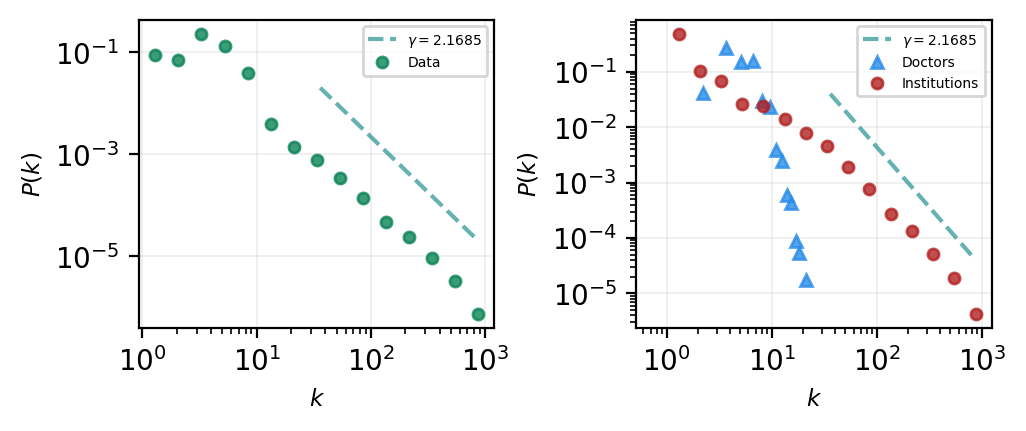

In [12]:
x, y = nh.distributions.degree_distribution(G)
fig, ax = plt.subplots(1,2,figsize=(5.5,2),dpi=200)

degree_sequence = np.array(list(dict(G.degree()).values()))
results = powerlaw.Fit(degree_sequence,verbose=False);
print(results.power_law.alpha)
print(results.power_law.xmin)

xvals = np.linspace(results.power_law.xmin, max(degree_sequence)*0.75)
slope_line = xvals ** (- results.power_law.alpha)
slope_line = slope_line/sum(slope_line)*0.05

ax[0].loglog(xvals, slope_line, label=r'$\gamma = %.4f$'%results.power_law.alpha,ls='--',color='teal', alpha = 0.6)

ax[0].loglog(x, y,'o', color='#0a8455', alpha=0.8,  ms = 4, label = 'Data')

ax[0].set_xlabel(r"$k$",fontsize='small')
ax[0].set_ylabel(r"$P(k)$",fontsize='small')
ax[0].grid(linewidth=0.7, color='#999999', alpha=0.15, linestyle='-')
# ax[0].set_title('Degree Distribution')
ax[0].legend(fontsize=5)

x0,y0,x1,y1,degs_0,degs_1 = bipartite_degrees(G, log_binning_0=False, log_binning_1=True)

results = powerlaw.Fit(degs_1,verbose=False);
print(results.power_law.alpha)
print(results.power_law.xmin)

xvals = np.linspace(results.power_law.xmin, max(degree_sequence)*0.75)
slope_line = xvals ** (- results.power_law.alpha)
slope_line = slope_line/sum(slope_line)*0.1

ax[1].loglog(xvals, slope_line, label=r'$\gamma = %.4f$'%results.power_law.alpha,ls='--',color='teal', alpha = 0.6)
ax[1].loglog(x0, y0,'^', color='#298ce9', alpha=0.8,  ms = 4, label = 'Doctors')

ax[1].set_xlabel(r"$k$",fontsize='small')
ax[1].set_ylabel(r"$P(k)$",fontsize='small')

ax[1].loglog(x1, y1,'o', color='firebrick', alpha=0.8,  ms = 4, label = 'Institutions')

ax[1].grid(linewidth=0.7, color='#999999', alpha=0.15, linestyle='-')
ax[1].legend(fontsize=5)

plt.subplots_adjust(wspace=0.40, hspace=0.05)

plt.savefig('../figs/degree_dist.pdf', dpi=425, bbox_inches='tight')
plt.savefig('../figs/degree_dist.png', dpi=425, bbox_inches='tight')

In [13]:
print(nx.number_connected_components(G))
print(nx.transitivity(G))
print(len(institutions))
# print(len(hospitals)) theres some overlap between hospitals and institutions - about 400 

1
0
8183


## Bipartite projection properties

In [14]:
B = G.copy()
doctors, institutions = nx.bipartite.sets(B)
projection_institutions = nx.bipartite.projected_graph(B, nodes= institutions, multigraph=True)
projection_doctors = nx.bipartite.projected_graph(B, nodes= doctors, multigraph=True)


In [23]:
degs= dict(projection_institutions.degree())
sorted_dict_desc = dict(sorted(degs.items(), key=lambda item: item[1], reverse=False))
print(sorted_dict_desc)

{'University of Nigeria College of ': 1, 'Athens Medical School, National & Kapodistrian University of Athens': 1, 'DMC': 1, 'UBA': 1, 'University of Jordan': 1, 'Khyber Medical College ': 1, 'Chiba University School of Medicine': 1, 'Tohoku University Faculty of Medicine': 1, 'Universidad de Cartegena': 1, 'Jilin University': 1, 'Ucsf': 1, 'Kyung Hee University College of Medicine': 1, 'Christian Medical College Vellore ': 1, 'Chinese University of Hong Kong Medical School': 1, "San Jorge Children's Hospital": 1, 'Father Muller Medical College ': 1, 'SCL Health - St. Vincent Healthcare': 1, 'Santiago de Compostela ': 1, 'Univ Cologne- Fac Med': 1, 'Red Lake Indian Health Service Hospital': 1, 'Hebrew University/ Hadassah': 1, 'Tehran ': 1, 'RajaRajeswari Medical College & Hospital': 1, 'Technion (Israel Institute of Technology)': 1, 'Atlantic University School of Medicine': 1, 'Pakistan': 1, 'IUMS': 1, 'Guwahati medical college': 1, 'October 6 University': 1, 'Astrakhan Med Acad': 1, 

In [24]:
degs= dict(projection_doctors.degree())
sorted_dict_desc = dict(sorted(degs.items(), key=lambda item: item[1], reverse=False))
print(sorted_dict_desc)

{7490: 3, 33703: 3, 12734: 5, 23467: 7, 35297: 8, 2786: 10, 22411: 10, 3994: 12, 19063: 12, 32085: 12, 26151: 13, 26972: 13, 11551: 14, 12079: 14, 12135: 14, 18240: 14, 26012: 14, 27131: 14, 1954: 15, 24085: 15, 25748: 15, 33842: 15, 36386: 15, 5450: 16, 26221: 16, 26718: 16, 26971: 16, 27078: 16, 32855: 16, 33662: 16, 24441: 17, 31454: 17, 901: 18, 1151: 18, 3485: 18, 3931: 18, 21676: 18, 21787: 18, 32644: 18, 32707: 18, 35061: 18, 2624: 19, 12118: 19, 12119: 19, 24833: 19, 25553: 19, 32278: 19, 6615: 20, 10246: 20, 15026: 20, 25487: 20, 32782: 20, 12764: 21, 14052: 21, 27761: 21, 21922: 22, 24735: 22, 25869: 22, 28967: 22, 31663: 22, 37356: 22, 19719: 23, 32189: 23, 10343: 24, 20460: 24, 30413: 24, 36859: 24, 19718: 25, 20028: 25, 23041: 25, 23803: 25, 24087: 25, 1026: 26, 1570: 26, 15624: 26, 16080: 26, 17635: 26, 31967: 26, 33415: 26, 10601: 27, 15976: 27, 23458: 27, 25925: 27, 27378: 27, 32830: 27, 37868: 27, 4612: 28, 11363: 28, 11730: 28, 14749: 28, 18503: 28, 20464: 28, 21329: 

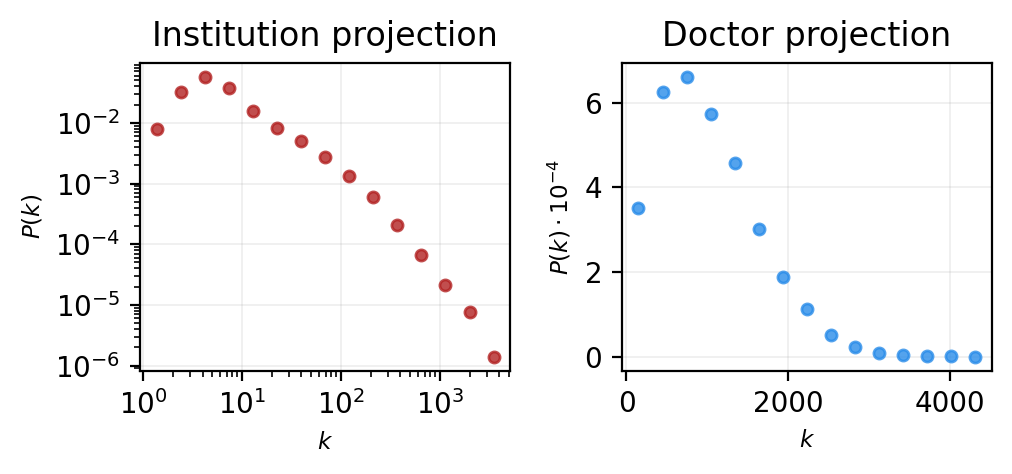

In [15]:

fig, ax = plt.subplots(1,2,figsize=(5.5,2),dpi=200)

x, y = nh.distributions.degree_distribution(projection_institutions)
ax[0].loglog(x, y,'o', color='firebrick', alpha=0.8,  ms = 4, label = 'Data')

ax[0].set_xlabel(r"$k$",fontsize='small')
ax[0].set_ylabel(r"$P(k)$",fontsize='small')
ax[0].grid(linewidth=0.7, color='#999999', alpha=0.15, linestyle='-')
ax[0].set_title('Institution projection')
# ax[0].legend(fontsize=5)

x, y = nh.distributions.degree_distribution(projection_doctors, log_binning=False)
ax[1].plot(x, y*10000,'o', color='#298ce9', alpha=0.8,  ms = 4, label = 'Data')

ax[1].set_xlabel(r"$k$",fontsize='small')
ax[1].set_ylabel(r"$P(k) \cdot 10^{-4}$",fontsize='small')
ax[1].grid(linewidth=0.7, color='#999999', alpha=0.15, linestyle='-')
ax[1].set_title('Doctor projection')

plt.subplots_adjust(wspace=0.30, hspace=0.05)
plt.savefig('../figs/projected_degree_dist.pdf', dpi=425, bbox_inches='tight')
plt.savefig('../figs/projected_degree_dist.png', dpi=425, bbox_inches='tight')

In [16]:
partition = community.best_partition(projection_institutions)

NameError: name 'community' is not defined

In [117]:
max(partition.values())

15

In [17]:
# Step 1: Calculate the degree of each node
node_degrees = dict(projection_institutions.degree())

# Step 2: Sort the nodes by degree in descending order and select the top 1000 nodes
top_1000_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[:1000]

# Step 3: Create a subgraph containing only the top 1000 nodes
subgraph = projection_institutions.subgraph(top_1000_nodes)

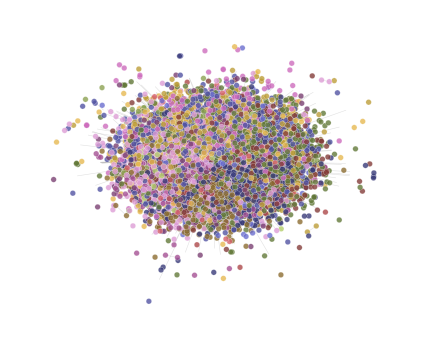

In [119]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2),dpi=200)

colors_sns = plt.cm.tab20b(np.linspace(0,1,len(np.unique(list(partition.values())))))
colors_nodes = [colors_sns[partition[node]] for node in projection_institutions.nodes()]

pos = nx.spring_layout(projection_institutions)
nx.draw_networkx_edges(projection_institutions, pos, width=0.2, edge_color='#666666', ax=ax, alpha=0.2)
nx.draw_networkx_nodes(projection_institutions, pos, node_size=4, node_color=colors_nodes, ax=ax, alpha=0.8,
                       edgecolors='w', linewidths=0.1)
ax.set_axis_off()

plt.savefig('../figs/institution_network.pdf', dpi=425, bbox_inches='tight')
plt.savefig('../figs/institution_network.png', dpi=425, bbox_inches='tight')

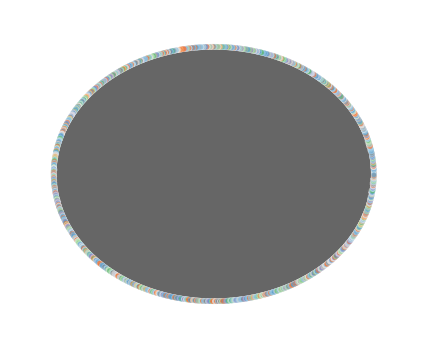

In [126]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2),dpi=200)

colors_sns = plt.cm.tab20c(np.linspace(0,1,len(np.unique(list(partition.values())))))
colors_nodes = [colors_sns[partition[node]] for node in subgraph.nodes()]

#pos = nx.spring_layout(projection_institutions)
pos = nx.circular_layout(subgraph)
nx.draw_networkx_edges(subgraph, pos, width=0.2, edge_color='#666666', ax=ax, alpha=0.2)
nx.draw_networkx_nodes(subgraph, pos, node_size=4, node_color=colors_nodes, ax=ax, alpha=0.8,
                       edgecolors='w', linewidths=0.1)
ax.set_axis_off()

plt.savefig('../figs/institution_network.pdf', dpi=425, bbox_inches='tight')
plt.savefig('../figs/institution_network.png', dpi=425, bbox_inches='tight')

In [18]:
def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    # if isinstance(key, unicode):
    #     # Encode the key as ASCII
    #     key = key.encode('ascii', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    # elif isinstance(value, unicode):
    #     tname = 'string'
    #     value = value.encode('ascii', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

In [28]:
gt_inst = nx2gt(projection_institutions)

In [29]:
state = gt.minimize_nested_blockmodel_dl(gt_inst)
state.draw()

In [19]:
gt_subgraph = nx2gt(subgraph)

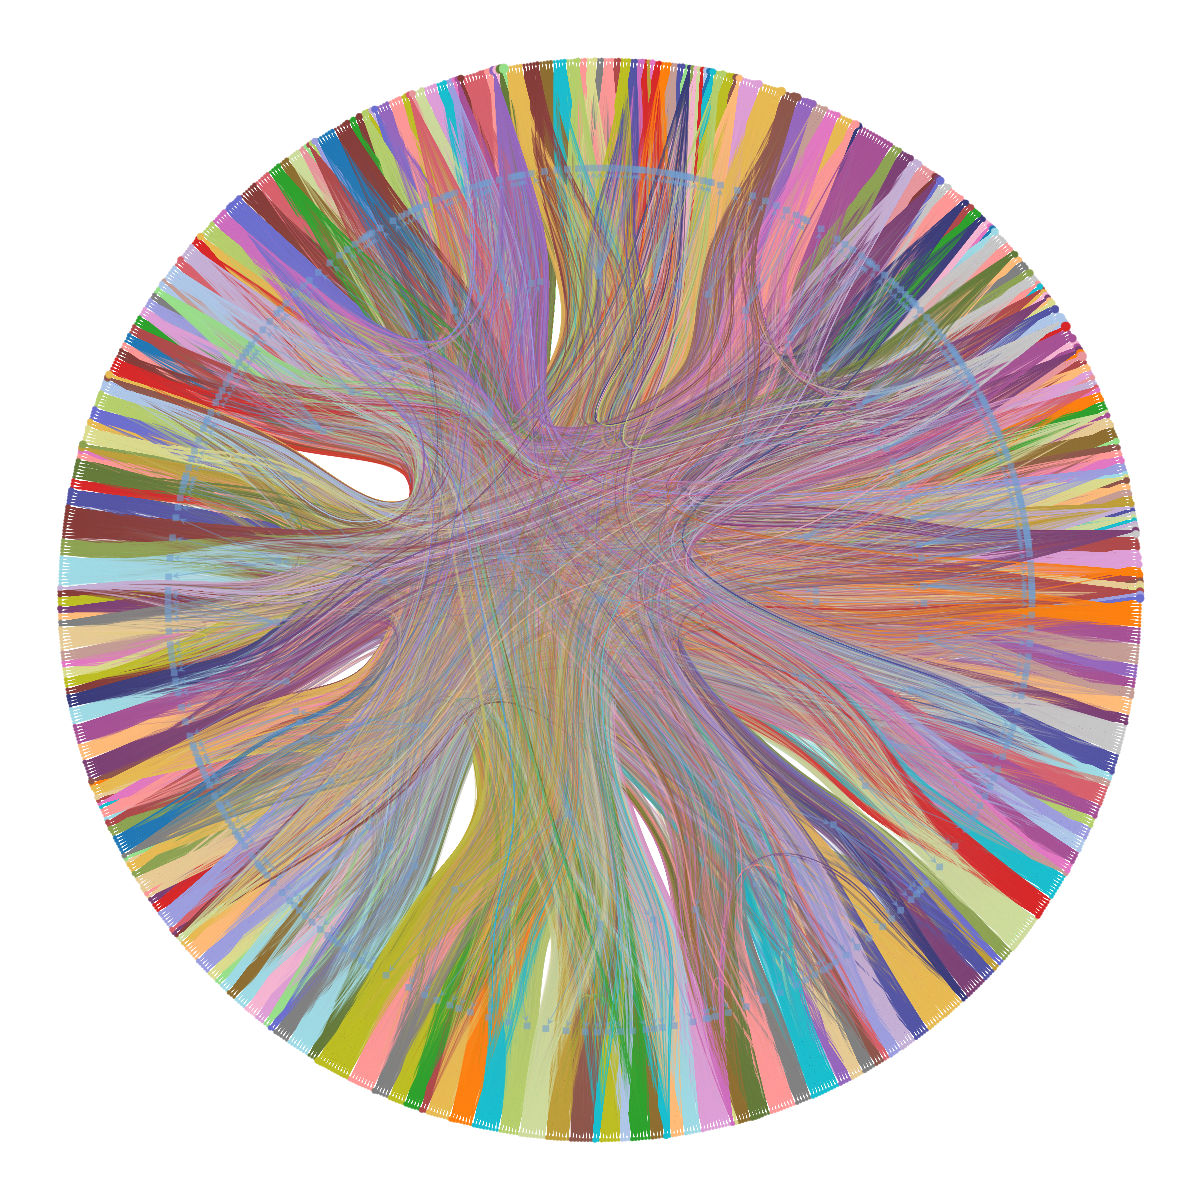

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x3241ee900, at 0x4d0e51a60>,
 <GraphView object, directed, with 1406 vertices and 1405 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x4c4a426c0, at 0x4c49bf6e0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x4c4a426c0, at 0x4c4aa1e50>, False), at 0x4c4a426c0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x4c4a426c0, at 0x32494bf80>)

In [20]:
gt_subgraph = nx2gt(subgraph)
state = gt.minimize_nested_blockmodel_dl(gt_subgraph)
state.draw()